# T7 - Calibration

We saw in Tutorial 4 how to load and plot data. But the next step is to actually *calibrate* the model to the data, i.e. find the model parameters that are the most likely explanation for the observed data. This tutorial gives an introduction to the Fit object and some recipes for optimization approaches.

## The Fit object

The Fit object is responsible for quantifying how well a given model run matches the data. Let's consider a simple example, building on Tutorial 4:

In [1]:
import covasim as cv
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

pars = dict(
    pop_size = 10_000,
    start_day = '2020-02-01',
    end_day   = '2020-04-11',
    beta      = 0.015,
)
sim = cv.Sim(pars=pars, datafile='example_data.csv', interventions=cv.test_num(daily_tests='data'))
sim.run()


Covasim 3.0.3 (2021-05-17) — © 2021 by IDM


Sim(<no label>; 2020-02-01 to 2020-04-11; pop: 10000 random; epi: 4172⚙, 19☠)

In [5]:
import pandas as pd
df = pd.read_csv('example_data.csv')
print(df)

          date  new_diagnoses  new_tests  new_deaths
0   2020-03-01              1         24           0
1   2020-03-02              3         22           0
2   2020-03-03              2         15           0
3   2020-03-04              8         40           0
4   2020-03-05             20         38           0
5   2020-03-06              9         61           0
6   2020-03-07              6         43           0
7   2020-03-08             13         98           0
8   2020-03-09              6         93           0
9   2020-03-10             25        170           0
10  2020-03-11             28        368           0
11  2020-03-12             27        437           0
12  2020-03-13             22        291           2
13  2020-03-14             43        328           0
14  2020-03-15             76       1147           0
15  2020-03-16             65       1438           1
16  2020-03-17             88       1209           0
17  2020-03-18             86       1269      

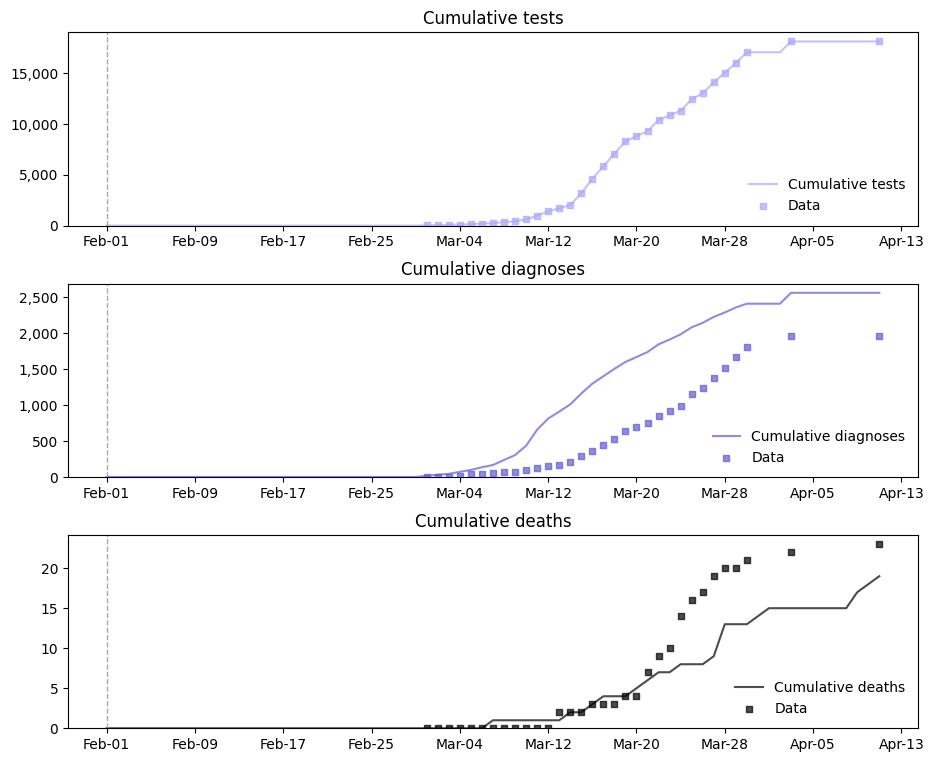

In [6]:
sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

We can see that tests match extremely well (they're input data!), diagnoses match reasonably well, and deaths match poorly. Can the Fit object capture our intuition about this?

In [2]:
fit = sim.compute_fit()
print(fit.mismatches)
print(fit.mismatch)

#0: cum_tests.     0.0
#1: cum_diagnoses. 34.03728294177732
#2: cum_deaths.    53.47826086956522
87.51554381134254


So the results seem to match our intuition. (Note that by default the Fit object uses normalized absolute difference, but other estimates, such as mean squared error, are also possible.)

What if we improve the fit? Does the mismatch reduce?

#0: cum_tests.     0.0
#1: cum_diagnoses. 33.20480081716037
#2: cum_deaths.    28.26086956521739
61.46567038237776


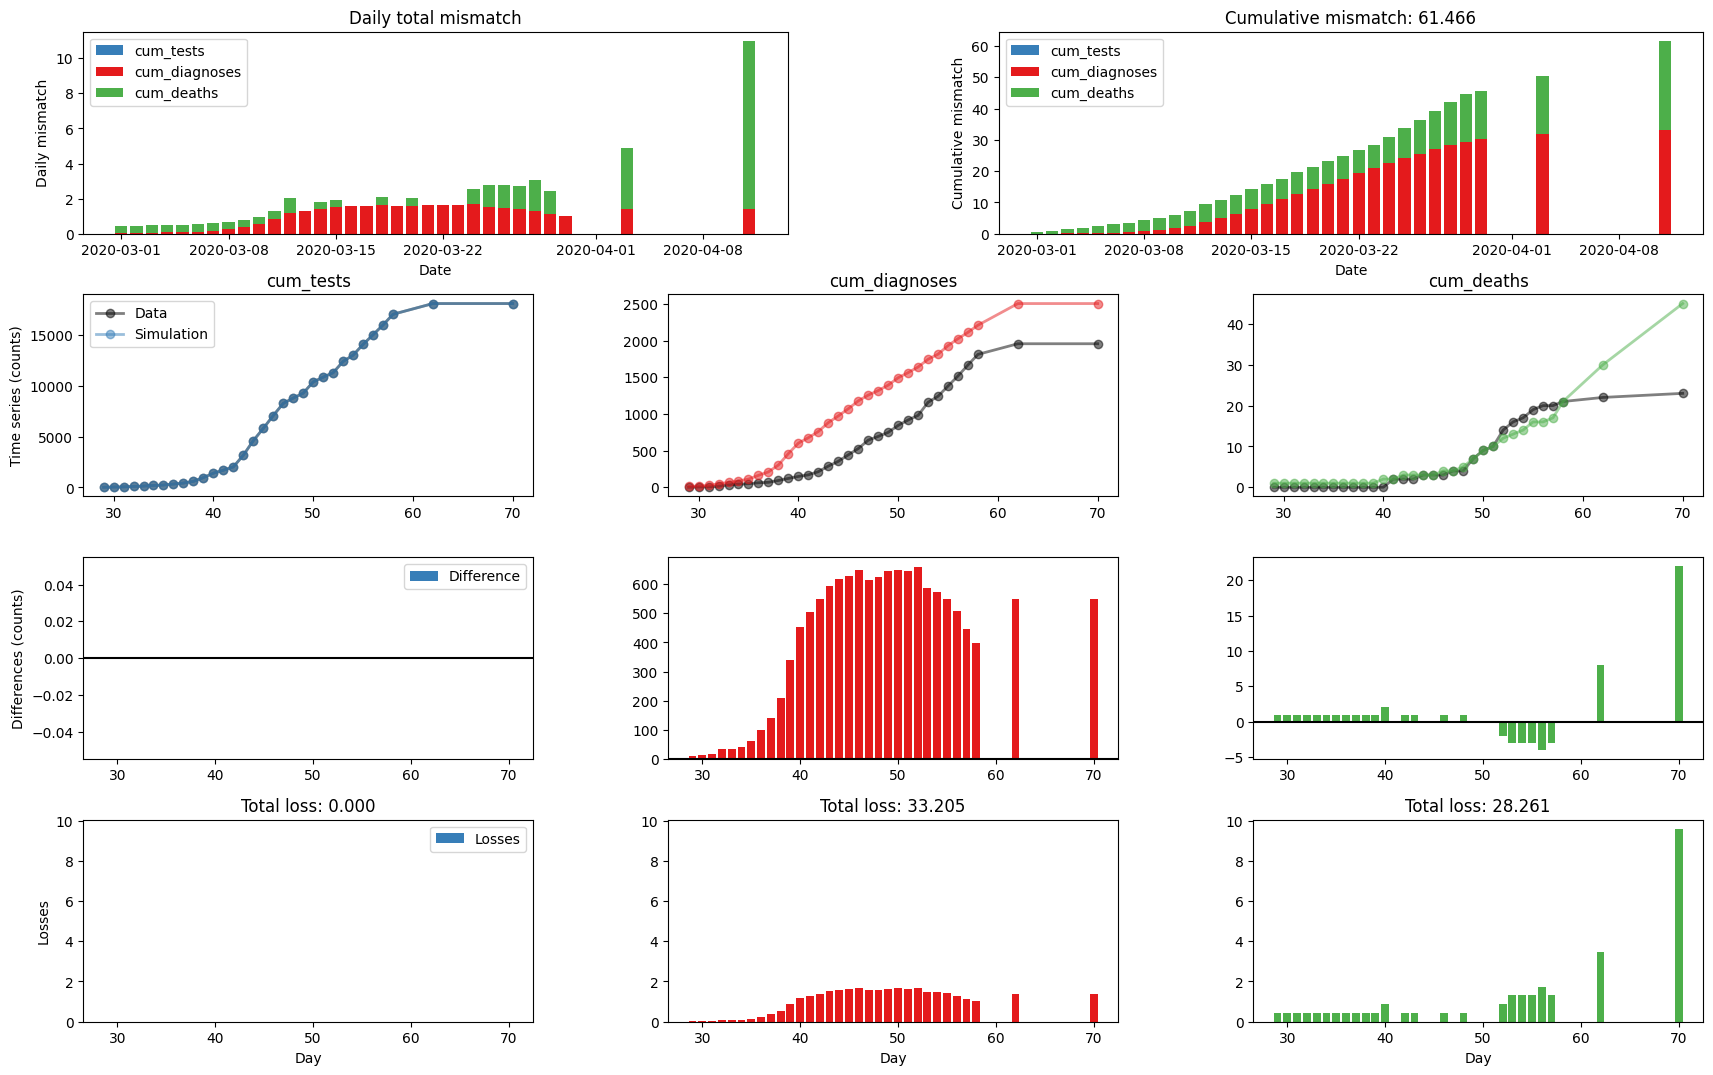

In [3]:
sim['rel_death_prob'] = 2 # Double the death rate since deaths were too low
sim.initialize(reset=True) # Reinitialize the sim

# Rerun and compute fit
sim.run()
fit = sim.compute_fit()

# Output
sim.plot()
fit.plot()
print(fit.mismatches)
print(fit.mismatch)

As expected, the fit is improved.

## Calibration approaches

Calibration is a complex and dark art and cannot be covered fully here; many books have been written about it and it continues to be an area of active research. A good review article about calibrating agent-based models like Covasim is available [here](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007893). Calibration is usually expressed as an optimization problem: specifically, find a vector of parameters *θ* that minimizes the mismatch between the data *D* and the model *M(θ)*.

In practice, most calibration is done simply by hand, as in the example above. Once deaths are "calibrated", the user might modify testing assumptions so that the diagnoses match. Since we are only fitting to deaths and diagnoses, the model is then "calibrated".

However, automated approaches to calibration are possible as well. The simplest is probably the built-in SciPy optimization functions, e.g. `scipy.optimize`. A wrinkle here is that normal gradient descent methods **will not work** with Covasim or other agent-based models, due to the stochastic variability between model runs that makes the landscape very "bumpy". One way of getting around this is to use many different runs and take the average, e.g.:

```python
import covasim as cv
import numpy as np
import scipy

def objective(x, n_runs=10):
    print(f'Running sim for beta={x[0]}, rel_death_prob={x[1]}')
    pars = dict(
        pop_size       = 10_000,
        start_day      = '2020-02-01',
        end_day        = '2020-04-11',
        beta           = x[0],
        rel_death_prob = x[1],
        verbose        = 0,
    )
    sim = cv.Sim(pars=pars, datafile='/home/cliffk/idm/covasim/docs/tutorials/example_data.csv', interventions=cv.test_num(daily_tests='data'))
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    mismatches = []
    for sim in msim.sims:
        fit = sim.compute_fit()
        mismatches.append(fit.mismatch)
    mismatch = np.mean(mismatches)
    return mismatch

guess = [0.015, 1] # Initial guess of parameters -- beta and relative death probability
pars = scipy.optimize.minimize(objective, x0=guess, method='nelder-mead') # Run the optimization
```

This should converge after roughly 3-10 minutes, although you will likely find that the improvement is minimal.

What's happening here? Trying to overcome the limitations of an algorithm that expects deterministic results simply by running more sims is fairly futile – if you run *N* sims and average them together, you've only reduced noise by √*N*, i.e. you have to average together 100 sims to reduce noise by a factor of 10, and even that might not be enough. Clearly, we need a more powerful approach.

## Built-in calibration

One such package we have found works reasonably well is called [Optuna](https://optuna.org/). It is built into Covasim as `sim.calibrate()` (it's not installed by default, so please install it first with `pip install optuna`). Do not expect this to be a magic bullet solution: you will likely still need to try out multiple different parameter sets for calibration, manually update the values of uncalibrated parameters, check if the data actually make sense, etc. Even once all these things are in place, it still needs to be run for enough iterations, which might be a few hundred iterations for 3-4 calibrated (free) parameters or tens of thousands of iterations for 10 or more free parameters. The example below should get you started, but best to expect that it will _not_ work for your particular use case without significant modification!

In [5]:
'''
Example for running built-in calibration with Optuna
'''

import sciris as sc
import covasim as cv

# Create default simulation
pars = sc.objdict(
    pop_size       = 10_000,
    start_day      = '2020-02-01',
    end_day        = '2020-04-11',
    beta           = 0.010,
    rel_death_prob = 1.0,
    interventions  = cv.test_num(daily_tests='data'),
    verbose        = 0,
)
sim = cv.Sim(pars=pars, datafile='example_data.csv')

# Parameters to calibrate -- format is best, low, high
calib_pars = dict(
    beta           = [pars.beta, 0.005, 0.20],
    rel_death_prob = [pars.rel_death_prob, 0.5, 3.0],
)

if __name__ == '__main__':

    # Run the calibration
    n_trials = 25
    n_workers = 4
    calib = sim.calibrate(calib_pars=calib_pars, n_trials=n_trials, n_workers=n_workers)

[I 2021-03-11 15:58:27,171] A new study created in RDB with name: my-example-calibration
[I 2021-03-11 15:58:28,896] Trial 1 finished with value: 244.05371497091087 and parameters: {'beta': 0.01824826549069546, 'rel_death_prob': 1.0818925721903123}. Best is trial 1 with value: 244.05371497091087.
[I 2021-03-11 15:58:29,722] Trial 0 finished with value: 118.69587422836078 and parameters: {'beta': 0.009708637485353805, 'rel_death_prob': 0.5627606411919845}. Best is trial 0 with value: 118.69587422836078.
[I 2021-03-11 15:58:30,013] Trial 2 finished with value: 144.61540169649598 and parameters: {'beta': 0.006123389295603373, 'rel_death_prob': 0.8592587625144819}. Best is trial 0 with value: 118.69587422836078.
[I 2021-03-11 15:58:30,970] Trial 3 finished with value: 406.1836612337345 and parameters: {'beta': 0.01805526840024343, 'rel_death_prob': 1.90766641001436}. Best is trial 0 with value: 118.69587422836078.
[I 2021-03-11 15:58:31,158] Trial 4 finished with value: 78.66722920460097 a



Output: {'beta': 0.013370818913529654, 'rel_death_prob': 2.7605943459698556}, time: 33.2 s


So it improved the fit (see above), but let's visualize this as a plot:

In [ ]:
# Plot the results
calib.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

Compared to `scipy.optimize.minimize()`, Optuna took less time and produced a much better fit. However, it's still far from perfect -- more iterations, and calibrating more parameters beyond just these two, would still be required before the model could be considered "calibrated".